In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Prototype Model

Generate the prototypes

In [4]:
def gen_prototypes(X_train, y_train):
    ai_proto = np.mean(X_train[y_train == 'ai'], axis=0)
    real_proto = np.mean(X_train[y_train == 'real'], axis=0)
    return ai_proto, real_proto

Categorize each exemplar in the training set by distance to prototype

In [5]:
def prototype_predict(ai_proto, real_proto, stims):
    predictions = []

    for stim in stims:
        dist_ai = -np.linalg.norm(stim - ai_proto)
        dist_real = -np.linalg.norm(stim - real_proto)
        if dist_ai > dist_real:
            predictions.append('ai')
        else:
            predictions.append('real')
    
    return np.array(predictions)

## Exemplar Model

Generate lists of exemplars

In [6]:
def gen_exemplars(X_train, y_train):
    exemplars = {
        'ai': X_train[y_train == 'ai'],
        'real': X_train[y_train == 'real']
    }
    return exemplars

Categorize each exemplar based on highest similarity score to each category

In [9]:
def exemplar_predict(stims, exemplars, c=2.0):
    predictions = []
    for stim in stims:
        # Calculate distances considering all dimensions 
        distances_ai = np.linalg.norm(exemplars['ai'] - stim.reshape(1, -1), axis=1)
        distances_real = np.linalg.norm(exemplars['real'] - stim.reshape(1, -1), axis=1)
        
        # Calculate similarity scores
        sim_ai = np.sum(np.exp(-c * distances_ai))
        sim_real = np.sum(np.exp(-c * distances_real))
        
        # Make prediction based on highest similarity
        predictions.append('real' if sim_real > sim_ai else 'ai')
            
    return np.array(predictions)

### Results (with ML)

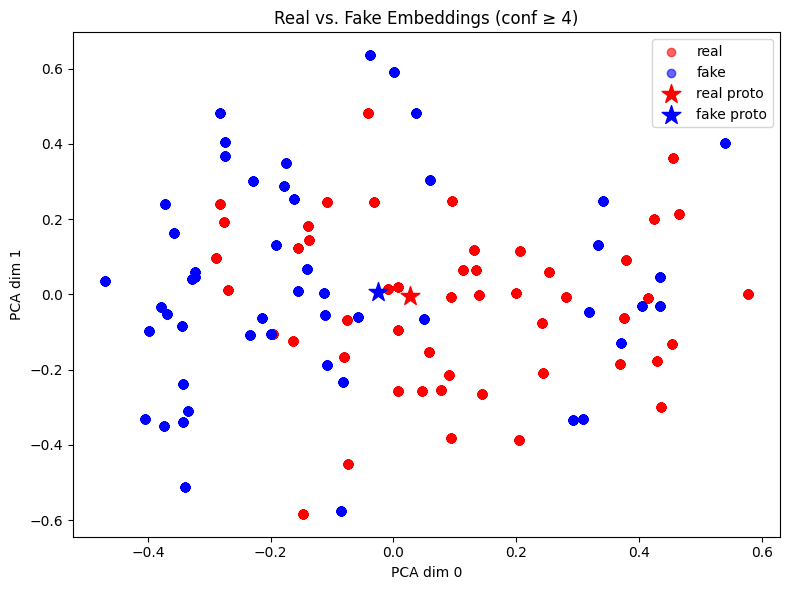

In [12]:
import matplotlib.pyplot as plt

df_resp = pd.read_csv("./DATA AND R CODE/eachresponse.csv")
df_resp = df_resp.dropna(how='any')

df = pd.read_pickle('df_pca_2')  
df["image"] = df["image"].str.extract(r'\((\d+)\)', expand=False)
df["image"] = df["image"].astype(int)

df_merged = pd.merge(df_resp, df, on="image", how="inner")
pca_columns = [i for i in range(0, 2)]

confidence = 4
df_merged = df_merged[df_merged["confidence"] >= confidence]

X = df_merged[pca_columns].values
y = df_merged["choice"].values

fake_proto, real_proto = gen_prototypes(X, y)

fig = plt.figure(figsize=(8, 6))
real = df_merged[df_merged['label'] == 'real']
fake = df_merged[df_merged['label'] == 'fake']

plt.scatter(real[0], real[1],
            color="red",   alpha=0.6, label="real")
plt.scatter(fake[0], fake[1],
            color="blue",  alpha=0.6, label="fake")

# prototypes
plt.scatter(real_proto[0], real_proto[1],
            color="red", marker="*", s=200,
            label="real proto")
plt.scatter(fake_proto[0], fake_proto[1],
            color="blue", marker="*", s=200,
            label="fake proto")

plt.xlabel("PCA dim 0")
plt.ylabel("PCA dim 1")
plt.title(f"Real vs. Fake Embeddings (conf ≥ {confidence})")
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# [1, 2, 3, 4, 5, 10, 20, 30, 50, 100]
pca_dfs = {
    1:  'df_pca_1',
    2:  'df_pca_2',
    3:  'df_pca_3',
    4:  'df_pca_4',
    5:  'df_pca_5',
    10: 'df_pca_10',
    20: 'df_pca_20',
    30: 'df_pca_30',
    50: 'df_pca_50',
    100:'df_pca_100'
}

results = []

df_resp = pd.read_csv("./DATA AND R CODE/eachresponse.csv")
df_resp = df_resp.dropna(how='any')

for d, df_pca in pca_dfs.items():
    df = pd.read_pickle(df_pca)  
    df["image"] = df["image"].str.extract(r'\((\d+)\)', expand=False)
    df["image"] = df["image"].astype(int)
    
    df_merged = pd.merge(df_resp, df, on="image", how="inner")
    pca_columns = [i for i in range(0, d)]
    
    confidence = 4
    df_merged = df_merged[df_merged["confidence"] >= confidence]
    
    X = df_merged[pca_columns].values
    y = df_merged["choice"].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Prototype
    ai_proto, real_proto = gen_prototypes(X_train, y_train)
    proto_preds = prototype_predict(ai_proto, real_proto, X_test)
    proto_acc = accuracy_score(y_test, proto_preds)

    # Exemplar
    exemplars = gen_exemplars(X_train, y_train)
    exemplar_preds = exemplar_predict(X_test, exemplars)
    exemplar_acc = accuracy_score(y_test, exemplar_preds)

    # ML (RidgeClassifier)
    clf = RidgeClassifier()
    clf.fit(X_train, y_train)
    ml_preds = clf.predict(X_test)
    ml_ridge_acc = accuracy_score(y_test, ml_preds)

    # ML (GradientBoostingClassifier)
    clf_gradientBoost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=3)
    clf_gradientBoost.fit(X_train, y_train)
    ml_gradientBoost_preds = clf_gradientBoost.predict(X_test)
    ml_gradientBoost_acc = accuracy_score(y_test, ml_gradientBoost_preds)

    # ML (AdaBoostClassifier)
    clf_adaBoost = AdaBoostClassifier(algorithm='SAMME', n_estimators=100)
    clf_adaBoost.fit(X_train, y_train)
    ml_adaBoost_preds = clf_adaBoost.predict(X_test)
    ml_adaBoost_acc = accuracy_score(y_test, ml_adaBoost_preds)
    
    # ML (KNeighborsClassifier)
    knn = KNeighborsClassifier(n_neighbors = 5)
    knn.fit(X_train, y_train)
    knn_preds = knn.predict(X_test)
    knn_acc = accuracy_score(y_test,knn_preds)

    # ML (BaggingClassifier)
    clf_bagging = BaggingClassifier(estimator = SVC(), n_estimators = 10)
    clf_bagging.fit(X_train, y_train)
    ml_bagging_preds = clf_bagging.predict(X_test)
    ml_bagging_acc = accuracy_score(y_test, ml_bagging_preds)

        # ML (Logistic Regression)
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    lr_preds = lr.predict(X_test)
    lr_acc = accuracy_score(y_test, lr_preds)

    # ML (SGDClassifier)
    sgd = SGDClassifier()
    sgd.fit(X_train, y_train)
    sgd_preds = sgd.predict(X_test)
    sgd_acc = accuracy_score(y_test, sgd_preds)
    
    # ML (DecisionTree)
    dt = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)
    dt.fit(X_train, y_train)
    dt_pred = dt.predict(X_test)
    dt_acc = accuracy_score(y_test, dt_pred)

    # ML (RandomForestClassifier)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_pred = clf.predict(X_test)
    rf_acc = accuracy_score(y_test, rf_pred)
    
    results.append({
        "dims": d,
        "prototype_acc": proto_acc,
        "exemplar_acc": exemplar_acc,
        "ml_ridge_acc": ml_ridge_acc,
        "ml_gradientBoost_acc": ml_gradientBoost_acc,
        "ml_adaBoost_acc": ml_adaBoost_acc,
        "ml_knn_acc": knn_acc,
        "ml_bagging_acc": ml_bagging_acc,
        "ml_log_reg": lr_acc,
        "ml_sgd_acc": sgd_acc,
        "ml_decis_tree_acc": dt_acc,
        "ml_random_forest_acc": rf_acc
    })

In [25]:
results_df = pd.DataFrame(results)
results_df

,dims,prototype_acc,exemplar_acc,ml_ridge_acc,ml_gradientBoost_acc,ml_adaBoost_acc,ml_knn_acc,ml_bagging_acc,ml_log_reg,ml_sgd_acc,ml_decis_tree_acc,ml_random_forest_acc
0,1,0.564713,0.566645,0.569865,0.658081,0.629105,0.616871,0.599485,0.569865,0.566645,0.632968,0.569865
1,2,0.566001,0.566645,0.573084,0.661301,0.633612,0.609144,0.594977,0.573084,0.566645,0.602061,0.573084
2,3,0.567933,0.566645,0.573084,0.661301,0.625885,0.619446,0.588538,0.573084,0.566645,0.620090,0.573084
3,4,0.569221,0.566645,0.574372,0.662589,0.633612,0.602704,0.631037,0.574372,0.566645,0.629105,0.574372
4,5,0.573084,0.566645,0.578236,0.661301,0.636832,0.618158,0.639408,0.578236,0.566645,0.636188,0.578236
5,10,0.564070,0.566645,0.587250,0.658725,0.640695,0.618802,0.653574,0.587250,0.566645,0.647778,0.587250
6,20,0.640052,0.566645,0.630393,0.662589,0.635544,0.585963,0.665164,0.631681,0.623954,0.636188,0.630393
7,30,0.643271,0.566645,0.641983,0.662589,0.663876,0.588538,0.660657,0.641983,0.632968,0.636188,0.641983
8,50,0.641983,0.566645,0.645203,0.658081,0.664520,0.588538,0.663232,0.643915,0.660013,0.654862,0.645203
9,100,0.641983,0.566645,0.645203,0.661301,0.660013,0.588538,0.662589,0.643915,0.650998,0.647135,0.645203


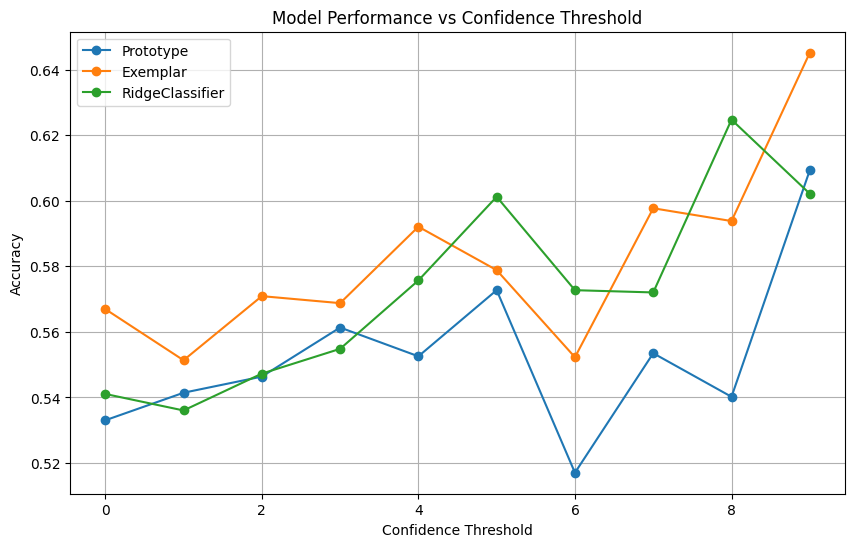

In [13]:
# Load PCA data and response data
df = pd.read_pickle('df_pca_2')
df["image"] = df["image"].str.extract(r'\((\d+)\)', expand=False)
df = df.dropna(subset=["image"])
df["image"] = df["image"].astype(int)

df_resp = pd.read_csv("./DATA AND R CODE/eachresponse.csv").dropna(how='any')

# Merge data on the "image" column
df_merged_all = pd.merge(df_resp, df, on="image", how="inner")
pca_columns = [i for i in range(0, 2)]

# Define a range of confidence thresholds to test
confidence_levels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
prototype_accs = []
exemplar_accs = []
ridge_accs = []

for conf in confidence_levels:
    # Filter merged DataFrame based on the current confidence threshold
    df_merged = df_merged_all[df_merged_all["confidence"] >= conf]

    # Skip if too few samples
    if len(df_merged) < 10:
        prototype_accs.append(None)
        exemplar_accs.append(None)
        ridge_accs.append(None)
        continue

    # Prepare data
    X = df_merged[pca_columns].values
    y = df_merged["choice"].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Prototype model
    ai_proto, real_proto = gen_prototypes(X_train, y_train)
    proto_preds = prototype_predict(ai_proto, real_proto, X_test)
    proto_acc = accuracy_score(y_test, proto_preds)

    # Exemplar model
    exemplars = gen_exemplars(X_train, y_train)
    exemp_preds = exemplar_predict(X_test, exemplars, c=5.0)
    exemp_acc = accuracy_score(y_test, exemp_preds)

    # ML model: RidgeClassifier
    clf = RidgeClassifier()
    clf.fit(X_train, y_train)
    ridge_preds = clf.predict(X_test)
    ridge_acc = accuracy_score(y_test, ridge_preds)
    
    # Save results
    prototype_accs.append(proto_acc)
    exemplar_accs.append(exemp_acc)
    ridge_accs.append(ridge_acc)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(confidence_levels, prototype_accs, marker='o', label='Prototype')
plt.plot(confidence_levels, exemplar_accs, marker='o', label='Exemplar')
plt.plot(confidence_levels, ridge_accs, marker='o', label='RidgeClassifier')
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy')
plt.title('Model Performance vs Confidence Threshold')
plt.legend()
plt.grid(True)
plt.show()